# Hadronization

Written by:

- Tony Menzo (School of Physics, University of Cincinnati) 
- Phil Ilten (School of Physics, University of Cincinnati)

In this tutorial, we'll develop an algorithm to hadronize a simple color-connected quark anti-quark ($q\bar{q}$) system.

Colliders probe energy scales where quarks and gluons interact perturbatively. As we saw in the previous tutorial, hard scattering events often produce colored partons that evolve via parton showers, radiating additional quarks and gluons. At the detector level, far below the QCD confinement scale, only color-neutral composite particles such as mesons, baryons, and occasionally exotic hadrons (e.g. tetraquarks or pentaquarks) are observed. To bridge this gap, Monte Carlo event generators must model the nonperturbative process that converts colored final state particles from the parton shower into observable hadrons. This process is known as hadronization. Many phenomenological models of hadronization exist, however, in modern event generators two models are favored: the Lund string model (Pythia) and the cluster model (Herwig, Sherpa). In this tutorial, we'll focus exclusively on the Lund string model.

## Requirements

This notebook requires a few external dependencies which are imported here. First we set up our plotting with `matplotlib`.

In [1]:
import matplotlib.pyplot as plt

# Some additional plotting utilities for visualizing the light-cone and Lund
# plane.
from matplotlib.transforms import Affine2D
from mpl_toolkits.axisartist.floating_axes import FloatingSubplot, GridHelperCurveLinear

Next, we have a few local utilities that we need to represent vectors and particles.

In [2]:
# Download the `vector` and `particle` modules.
!wget -q -N https://gitlab.com/mcgen-ct/tutorials/-/raw/main/.full/mc/vector.py
!wget -q -N https://gitlab.com/mcgen-ct/tutorials/-/raw/main/.full/mc/particle.py

# Import the necessary classes.
from vector import FourVector
from particle import ParticleDatabase, ParticleData, Particle

We will also need some particle data. We will use the Pythia particle data, which can be read by the `pdb` class we just imported.

In [3]:
# Download the Pythia particle database.
!wget -q -N https://gitlab.com/mcgen-ct/tutorials/-/raw/main/.full/mc/data/ParticleData.xml

# Create a particle database we can use throughout this notebook.
pdb = ParticleDatabase()

Finally, we need a random number generator. We could use one of the RNGs implemented in [`rng.ipynb`](rng.ipynb), but instead we will use the default `numpy` RNG. We also need the `math` module.

In [4]:
# Import the `numpy` and `math` modules.
import numpy as np
import math

# Create an RNG, with a seed of 10.
rng = np.random.default_rng(10)

## Lund string model

In QCD the potential between a static quark and anti-quark as a function of the distance between them is found to be

$$
V_{q\bar{q}}(r) \approx -\frac{4\alpha_s}{3}\frac{1}{r} + \kappa r .
$$

At short distances ($r < 0.1$ fm), the $1/r$ piece (stemming from one-gluon exchange (stemming from one-gluon exchange) dominates and the quarks behave as free "Coulomb-like" charged particles. At long distances, the linear component dominates, representing the collapse of gluonic field lines into a thin color flux tube or string with a constant tension (linear energy density) $\kappa \simeq 1 \text{ GeV/fm} \simeq 0.2 \text{ GeV}^2$.

The idea behind the Lund string model is that as a quark/anti-quark pair separate in position space, this flux tube is stretched out and the potential increases. At some point, it is more favorable to produce a new quark/anti-quark pair and break the string. The idea is that some initial string breaks multiple times to produce final state hadrons.

## String breaking

Consider center-of-mass frame of a $q_i \bar{q}_i$ system where the (massless) partons, each with flavor index $i$ and initial energy $E$, travel with equal and opposite momenta along the $z$-axis. As the separation increases the confining force causes an approximately uniform cylindrical string (flux tube) of color field to form between the quark pair. In the absence of string breaks, our $q\bar{q}$ system would follow an infinite "yo-yo" motion whereby the the systems energy oscillates between the kinetic energy of the quarks and the energy contained in the string.

If we allow for string breaking during the separation process the energy in the string can be used to create $q'\bar{q}'$ pairs out of the vacuum. This production breaks the original string into two fragments: a composite hadron $h \equiv  q_i\bar{q}'$ (or $q' \bar{q_i}$) and another $q'\bar{q}_i$ (or $q_i \bar{q}'$)-string system. The ejected hadron inherits kinematics according to the model (and whose microscopic description in this model would be that of a mini-string following stable yo-yo motion as described above, i.e., yoyo-hadrons). The remaining string system continues its evolution and potentially fragments further into more hadrons.

![Schematic illustration phase-space cuts.](https://github.com/mcgen-ct/tutorials/blob/main/.full/mc/figures/hadronization.png?raw=1)

### Exercise: particle data

Before we get started creating a string system, we should make sure we understand how to work with the particle database. Access a charged pion and print all the relevant data that is stored for it.

In [5]:
# Get the charged pion.
pd = pdb["pi+"]

# Loop over its members and print.
for key, val in pd.__dict__.items():
    print(f"--\n{key}: {val}")

--
pid: 211
--
name: pi+
--
mass: 0.13957
--
tau: 7804.5
--
spin: 1
--
charge: 3
--
colour: 0
--
anti:    pid: -211
  name: pi-
  mass: 0.13957
   tau: 7804.5
  spin: 1
charge: -3
colour: 0


### Exercise: string system

We can now write a class to represent our string system consisting of two `Particle` instances.

In [6]:
class QQBarString:
    """
    Class to represent a quark-antiquark string system.
    """

    def __init__(self, e, pd):
        """
        Initialize a symmetric q-qbar string system.

        e:  energy of either string end in GeV.
        pd: `ParticleData` for the type of quark.
        """
        # Store the string-end energy.
        self.e = e

        # Define the particles.
        self.q = Particle(pd, FourVector(e, 0, 0, e), 0)
        self.qbar = Particle(-pd, FourVector(e, 0, 0, -e), 0)

        # Store the string mass squared, ignoring thes masses of the quarks.
        self.m2 = 4 * e**2

    def __str__(self):
        """
        Return a string to print this string system.
        """
        return f"q\n{self.q}qbar\n{self.qbar}"

Create an instance of this string system with a string end energy of $50$ GeV and $u/\bar{u}$ string ends. How do you access the momentum vector for each string end?

In [7]:
# Define the energy for each string end.
e = 50.0

# Create a QQBarString instance with the u/ubar ends.
qqbar = QQBarString(e, pdb["u"])

# Print the string system.
print(qqbar)

# Print the momentum for each string end.
print(f"q:    {qqbar.q.p}")
print(f"qbar: {qqbar.qbar.p}")

q
  data: ParticleData(2, 'u', 0.33, 0.0, 2, 2, 1)
     p: FourVector(50.0, 0, 0, 50.0)
     t: FourVector(0, 0, 0, 0)
h, c, a: 0.00e+00, 0, 0
qbar
  data: ParticleData(-2, 'ubar', 0.33, 0.0, 2, -2, 1)
     p: FourVector(50.0, 0, 0, -50.0)
     t: FourVector(0, 0, 0, 0)
h, c, a: 0.00e+00, 0, 0

q:    50.0 0 0 50.0
qbar: 50.0 0 0 -50.0


## String Coordinates

In the string model, hadronization is typically implemented in momentum space as an iterative random walk through production (string-break) vertices, $v_i$. If we assume each string end to be massless, mass corrections can be incorporated later, they both follow light-like trajectories, motivating the use of light-cone coordinates. Given an arbitrary four-momentum $p^\mu = (E, \vec{p})$, the light-cone momenta are defined as:

$$
p^\pm = E \pm p_z
$$

and satisfy (in $1 + 1$ dimensions)

$$
p^+ p^- = m^2.
$$

Under Lorentz boosts, light-cone momenta have simple transformation properties

$$
p^{\pm'} = e^{\pm \psi} p^\pm, \quad \text{where } \psi = \frac{1}{2}\ln{\frac{1+\beta}{1-\beta}}
$$

with $\beta$ defined as the boost velocity divided by the speed of light, $v/c$.

The string itself has total light-cone momenta (defined at $t = 0$):

$$
P^+ = p_q^+ + p_{\bar{q}}^+, \quad P^- = p_q^- + q_{\bar{q}}^-
$$

which in the string rest frame (both ends with equal energy, $E$, and opposite momenta along the $z$-axis, $p_z$) becomes,

$$
P^+ = 2E, \quad P^- = 2E, \quad P^+ P^- = M^2 = 4 E^2.
$$

where $M$ is the string mass.

To further describe the fragmentation in dimensionless and string-normalized coordinates we also introduce light-cone momentum fractions, $x^{\pm}$. These represent the light-cone separation between two breaks and are defined as

$$
x_i^{\pm} = \frac{p_i^\pm}{P^\pm}
$$

for the $i$-th hadron. These satisfy:

$$
x^+_i x^-_i = \frac{m_i^2}{M^2}.
$$

For a specified hadron mass, we thus have a fixed relationship between $x^+_i$ and $x^-_i$. Note that the momentum fractions are normalized to the quark turning points such that $0 \leq x^{\pm} \leq 1$. The figure below gives a useful schematic depiction of a fully hadronized string in energy-momentum space.

![String system in momentum space.](https://github.com/mcgen-ct/tutorials/blob/main/.full/mc/figures/string.png?raw=1)

where $\hat{x}^{\pm}$ represent the light-cone vertex coordinates, describing the location of production vertices.

Very broadly, the hadronization of a string can be factorized into two components.
1. **flavor production**: we need to choose the flavor of the hadrons that get produced and
2. **kinematics**: we need to assign some four-momenta to each of the produced hadrons.
Before jumping into the full hadronization algorithm we'll take a detour to build each of these components.

## Flavor

Here, for simplicity, we'll restrict the string breaks to $u\bar{u}$ and $d\bar{d}$ pairs, implying that the only (stable) hadrons available for production are the pions $\pi^\pm and \pi^0$. This makes the problem of choosing hadron flavor relatively straight forward. For example, each of the four possible string ends have a unique assignment depending on the flavor of the break:
1. $u$ string end
    * $u\bar{u}$ string break $\to \pi^0$
    * $d\bar{d}$ string break $\to \pi^+$
2. $\bar{u}$ string end
    * $u\bar{u}$ string break $\to \pi^0$
    * $d\bar{d}$ string break $\to \pi^-$
3. $d$ string end
    * $u\bar{u}$ string break $\to \pi^-$
    * $d\bar{d}$ string break $\to \pi^0$
4. $\bar{d}$ string end
    * $u\bar{u}$ string break $\to \pi^+$
    * $d\bar{d}$ string break $\to \pi^0$

So, given a string end, we can randomly select between a $u\bar{u}$ or $d\bar{d}$ break and assign hadron flavor accordingly.

In [8]:
class StringFlav:
    """
    Class to select a hadron flavor, given a string end.
    """

    def __init__(self, rng, pdb):
        """
        Initialize, given a random number generator and particle database.

        pdb: `ParticleDatabase` object to access particle data.
        """
        self.rng = rng
        self.pdb = pdb

    def __call__(self, end_pd):
        """
        Return a new string end and hadron, each of type `ParticleData`.

        end_pd: `ParticleData` object of the string end.
        """
        # Given the string end, determine the possible hadrons and their
        # corresponding probabilities. Given our simplified scenario,
        # all the probabilites are [1/2, 1/2].
        if end_pd.name == "u":
            hadron_pds = [self.pdb["pi0"], self.pdb["pi-"]]
            hadron_wgts = [1 / 2, 1 / 2]
        elif end_pd.name == "ubar":
            hadron_pds = [self.pdb["pi0"], self.pdb["pi+"]]
            hadron_wgts = [1 / 2, 1 / 2]
        elif end_pd.name == "d":
            hadron_pds = [self.pdb["pi0"], self.pdb["pi+"]]
            hadron_wgts = [1 / 2, 1 / 2]
        elif end_pd.name == "dbar":
            hadron_pds = [self.pdb["pi0"], self.pdb["pi-"]]
            hadron_wgts = [1 / 2, 1 / 2]
        else:
            print(f"Error: unsupported end_id {end_pd.pid}")
            return self.pdb["void"], self.pdb["void"]

        # Select a hadron flavor based on the weights.
        hadron_pd = rng.choice(hadron_pds, p=hadron_wgts)

        # Use flavor conservation to determine the new string end.
        # This list of PIDs are the constituent quark PIDs of the hadron.
        quark_pids = hadron_pd.quarks()
        # If the first quark matches the string end, use the second quark as
        # the new string end, and vice versa.
        if quark_pids[0] == abs(end_pd.pid):
            new_pid = quark_pids[1]
        elif quark_pids[1] == abs(end_pd.pid):
            new_pid = quark_pids[0]
        else:
            new_pid = abs(end_pd.pid)

        # Flip the sign if needed.
        if end_pd.pid < 0:
            new_pid = -new_pid

        # Return the new string end and hadron.
        return self.pdb[new_pid], hadron_pd

Veryify that this selector correctly selects the flavor scenarios as outlined above.

In [9]:
# Create the selector.
flavor_selector = StringFlav(rng, pdb)
# Loop over the initial state quarks.
for i, end_pd in enumerate([pdb["u"], pdb["ubar"], pdb["d"], pdb["dbar"]]):
    # Print the string end.
    print(f"({i + 1}) {end_pd.name}")

    # Sample a few times, and book-keep the states.
    states = {}
    for j in range(0, 1000):
        new_pd, hadron_pd = flavor_selector(end_pd)
        key = (new_pd, hadron_pd)
        if not key in states:
            states[key] = 1
        else:
            states[key] += 1

    # Print the result.
    total = sum([n for pds, n in states.items()])
    states = [(n, pds) for pds, n in states.items()]
    states.sort()
    for n, (new_pd, hadron_pd) in states:
        print(f" -> {(n/total):.2f} {new_pd.name}, {hadron_pd.name}")

(1) u
 -> 0.49 d, pi-
 -> 0.51 u, pi0
(2) ubar
 -> 0.49 dbar, pi+
 -> 0.51 ubar, pi0
(3) d
 -> 0.48 u, pi+
 -> 0.52 d, pi0
(4) dbar
 -> 0.49 dbar, pi0
 -> 0.51 ubar, pi-


### Exercise: include baryons

How might baryon production be minimally included in the string model? The implementation is relatively non-trivial, we are not asking you to do that here, but rather just think about possible solutions. Identify the relevant particles in the particle database that could make this implementation possible. Hint, these particles have PIDs between 1000 and 6000.

If we want to produce a baryon, then this means that for a given string break we at a minimum we need to produce three quarks/anti-quarks plus the new string end, so four quarks/anti-quarks in total. Consider the following example.

$$
u \to \bar{q} ~(udd)
$$

There is no way that we can assign $\bar{q}$ without violating quark number conservation, so that means that we really need to produce five.

$$
u \to (\bar{q}_i\bar{q}_k) ~(udd)
$$

Now, we can actually assign $\bar{q}_i$ and $\bar{q_k}$ to make this work.

$$
u \to (\bar{d}\bar{d})_j ~(udd)
$$

This composite object, $\bar{d}\bar{d})_j$ we call a diquark, where $j$ indicates the spin of that diquark. In this case $j = 1$.

In [10]:
# Loop over the particle database.
diquark_pds = []
for name, pd in pdb.items():
    # Only look at the integer keys.
    if type(name) == int and 1000 < name < 6000:
        # Require exactly 2 quarks.
        quark_pids = pd.quarks()
        if len(quark_pids) == 2:
            diquark_pds += [pd]

# Sort and print the diquarks.
diquark_pds.sort()
for diquark_pd in diquark_pds:
    print(diquark_pd.name)

dd_1
ud_0
ud_1
uu_1
sd_0
sd_1
su_0
su_1
ss_1
cd_0
cd_1
cu_0
cu_1
cs_0
cs_1
cc_1
bd_0
bd_1
bu_0
bu_1
bs_0
bs_1
bc_0
bc_1
bb_1


## Kinematics

In the flavor selection of the previous selection, it is important to note that in our factorization, the flavor does not depend upon the kinematics. This is actually quite important when implementing the string model. It means that we can first select the flavor, and then select kinematics. It is important to note, however, that in some variants of the string model, the flavor does depend on the kinematics. This complicates the algorithm because the kinematics and flavor need to be either selected iteratively, or simulateously.

In any case, with the model that we are building here, flavor does not depend upon kinematics. This means that we can now turn to sampling kinematics, assuming we already have selected a flavor.

The longitudinal momentum fraction, $z$, is defined as the fraction of longitudinal momentum (light-cone momentum $p^{\pm}_i$) absorbed by the $i$-th hadron from the remaining longitudinal momentum in the string system. This is similar, but distinct, from the light-cone momentum fractions we defined above. They are related by,

$$
x^+_1 = z_1, \quad x^+_i = z_i \prod_{j = 1}^{i-1}(1-z_j)\text{ for }i > 1.
$$

From the transformations defined above, we see that $z^\pm$ is manifestly invariant under boosts. The distribution from which $z$ is sampled is called the Lund left-right symmetric scaling fragmentation function, which is quite a mouthful so we will abbreviate it the LFF (Lund fragmentation function). The LFF is proportional to the following

$$
f(z)\,\text{d}z \propto \frac{(1-z)^a}{z}\exp \left(-b \frac{m_h^2}{z} \right) \,\text{d}z
$$

where $a$ and $b$ are tuneable phenomenological parameters fit to empirical data. Why do we only give the proportionality? It turns out normalizing this function to be a proper probability distribution function is not quite so trivial.

It turns out that it is even harder to sample this distribution. If you need some more details on how to sample distributions, take a look at [`integrate.ipynb`](integrate.ipynb); good luck integrating and inverting this function. This means that we will need to use some other technique, so let's start off with accept-and-reject.

### Exercise: the Lund fragmentation function

It turns out that it is even harder to sample this distribution. If you need some more details on how to sample distributions, take a look at [`integrate.ipynb`](integrate.ipynb); good luck integrating and inverting this function. This means that we will need to use some other technique, so let's start off with accept-and-reject. Since we will be slightly concerned with efficiency, we should also track the accept and rejects of this method.

In [11]:
class StringZFlat:
    """
    Class to sample the Lund fragmentation function using flat
    accept-and-reject.
    """

    def __init__(self, rng, a=0.68, b=0.98, fmax=10):
        """
        Create a Lund fragmentation function sampler. The
        default `a` and `b` values are taken from the Monash tune.

        rng:  random number generator for sampling.
        a:    `a` parameter from the LFF.
        b:    `b` parameter from the LFF.
        fmax: maximum value for the LFF.
        """
        # Store the members of this class.
        self.rng = rng
        self.a = a
        self.b = b
        self.fmax = fmax
        # Only print the warnings once.
        self.warn_over = True
        self.warn_nmax = True
        # Track the accept and rejects.
        self.accept = 0
        self.reject = 0

    def e(self):
        """
        Return the current efficiency of the sampler.
        """
        return self.accept / (self.accept + self.reject)

    def f(self, z, m):
        """
        Return the Lund fragmentation function.

        z: longitudinal momentum fraction.
        m: mass of the hadron.
        """
        if z == 0:
            return 0.0
        return ((1 - z) ** self.a / z) * math.exp(-(self.b * m**2) / z)

    def __call__(self, m, nmax=1000):
        """
        Sample the Lund fragmentation function given a mass `m`.

        m:    hadron mass to use when sampling.
        nmax: number of times to sample before returning.
        """
        # Loop over maximum number of samples.
        for i in range(0, nmax):
            # Uniformly sample `z`.
            z = self.rng.uniform()
            # Calculate `f`.
            f = self.f(z, m)
            # Sample a number between 0 and `fmax`.
            u = rng.uniform() * self.fmax
            # Warn if we exceed our maximum.
            if f > self.fmax and self.warn_over:
                print("Warning: f(z) > f_max(z)")
                self.warn_over = False
            # Return if accepted.
            if u < f:
                self.accept += 1
                return z
            else:
                self.reject += 1
        # Return, but warn about attempts.
        if self.warn_nmax:
            print("Warning: sampling f(z) exceeded `nmax` attempts")
        self.warn_nmax = False
        return 0.0

Now we can sample some $z$ values.

In [12]:
# Create an LFF sampler.
kinematic_sampler = StringZFlat(rng)

# Set the mass to sample, use the pi+.
m = pdb["pi+"].mass

# Generate 10000 random z values.
rzs = [kinematic_sampler(m) for i in range(0, 10000)]
print(f"sampling efficieny = {kinematic_sampler.e()}")

sampling efficieny = 0.23838470523731198


Ideally, we would like to know whether these $z$ values match our target distribution from the LFF. Set up a regularly spaced grid of $z$ values, calculate the LFF for each, and then normalize these values using numerical integration (the mid-point rule is sufficient).

In [13]:
# Set up vector of z values to calculate the LFF.
azs = np.linspace(0, 1, 1000)

# Calculate the analytic LFF values.
afs = [kinematic_sampler.f(z, m) for z in azs]

# Calculate normalization factor by the mid-point rule.
dz = azs[1] - azs[0]
nf = sum(afs) * dz

# Normalize the `afs`.
afs = [f / nf for f in afs]

Now we plot the sampled distribution and analytic function, and compare.

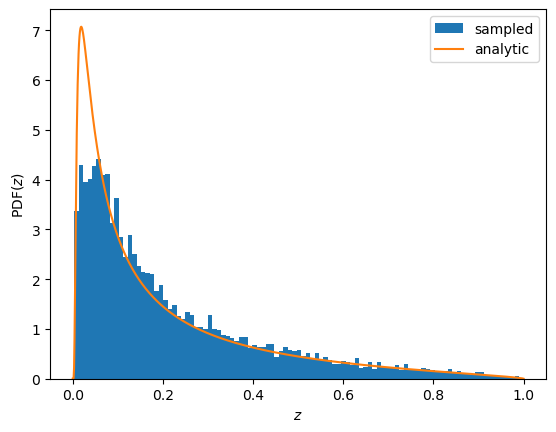

In [14]:
# Create the plot.
fig, ax = plt.subplots()

# Plot a normalize histogram of the sampled values.
ax.hist(rzs, bins=100, density=True, label="sampled")
ax.set_xlabel(r"$z$")
ax.set_ylabel("PDF($z$)")

# Plot the normalized analytic LFF.
ax.plot(azs, afs, label="analytic")
ax.legend()

This does not look so good, so what is going on? It turns out that we don't have the maximum of our function correct. We have taken a maximum of `fmax = 10`, so how badly do we violate this?

In [15]:
print(f"fmax = {max([kinematic_sampler.f(z, m) for z in azs])}")

fmax = 19.02047908770195


It turns out that this is not so bad. Go back and see what happens if you increase your `fmax` when sampling $z$. Hopefully your distribution looks a little better. However, we are not very efficient with our sampling. Below, we implement a more efficient sampler using importance sampling.

### Exercise: better sampling

First, we need to get a better picture for what the LFF looks like for different parameters. Choose a selection of $a$, $b$, and $m$ and plot the LFF.

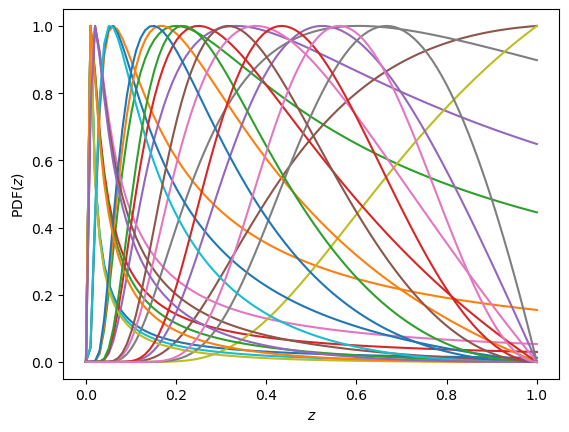

In [16]:
# Set up vector of z values to calculate the LFF.
azs = np.linspace(0, 1, 100)

# Create the plot.
fig, ax = plt.subplots()
ax.set_xlabel(r"$z$")
ax.set_ylabel("PDF($z$)")

# Loop over the a and b parameter space.
for a in np.linspace(0, 2, 3):
    for b in np.linspace(0.2, 2, 3):
        for m in np.linspace(0.1, 1, 3):
            # Get the analytic values of the LFF.
            kinematic_sampler = StringZFlat(rng, a, b)
            afs = [kinematic_sampler.f(z, m) for z in azs]
            fmax = max(afs)
            afs = [f / fmax for f in afs]

            # Plot the analytic LFF.
            ax.plot(azs, afs, label="analytic")

Turns out this is a surprisingly complicated function. In Pythia, there is quite a bit of technical work that is done to sample this efficiently, which we are not going to do here.

It is important to note that the what really changes the distribution is the mass of the hadron. So, if we limit the range of the hadron mass, this also means we can be more efficient with our sampling. So, let's do this and then perform importance sampling using a linear function defined as follows.

1. Determine the maximum $f_\max(z, m)$ within the range of $m$.
2. Determine the maximum $f(1, m)$ within the range of $m$.
3. Use these two points to define the oversampling function $g(z)$.

There is some question about how we sample $g(x)$. We can either do this entirely analytically, or with multichannel sampling. Here, we opt for analytically.

In [17]:
class StringZ:
    """
    Class to sample the Lund fragmentation function using
    multi-channel sampling.
    """

    def __init__(self, rng, a=0.68, b=0.98, mlim=(0.12, 0.15)):
        """
        Create a Lund fragmentation function sampler.

        rng:  random number generator for sampling.
        a:    `a` parameter from the LFF.
        b:    `b` parameter from the LFF.
        mlim: limits on the hadron mass for sampling.
        """
        # Store the members of this class.
        self.rng = rng
        self.a = a
        self.b = b
        # Only print the warnings once.
        self.warn_over = True
        self.warn_nmax = True
        # Track the accept and rejects.
        self.accept = 0
        self.reject = 0

        # Scan the sampling grid.
        f1, z1 = 0, 0
        f2, z2 = 0, 1
        n = 0 if mlim[0] == mlim[1] else 100
        for m in np.linspace(mlim[0], mlim[1], n):
            for z in np.linspace(0, 1, 100):
                f = self.f(z, m)
                if f > f1:
                    f1, z1 = f, z
            if f > f2:
                f2, z2 = f, 1.0

        # Build the slope-intercept form.
        if z1 == z2:
            self.g_m = 0
            self.g_b = f1
        else:
            self.g_m = (f2 - f1) / (z2 - z1)
            self.g_b = f1 - self.g_m * z1

        # Calculate the area and G(z_min).
        self.area = self.G(1) - self.G(0)
        self.g0 = self.G(0)

    def e(self):
        """
        Return the current efficiency of the sampler.
        """
        return self.accept / (self.accept + self.reject)

    def f(self, z, m):
        """
        Return the Lund fragmentation function.

        z: longitudinal momentum fraction.
        m: mass of the hadron.
        """
        if z == 0:
            return 0.0
        return ((1 - z) ** self.a / z) * math.exp(-(self.b * m**2) / z)

    def g(self, z):
        """
        Return the oversampling function.
        """
        return self.g_m * z + self.g_b

    def g_rand(self):
        """
        Sample the oversampling function.
        """
        r = self.rng.uniform()
        return self.G_inv(self.g0 + self.area * r)

    def G(self, z):
        """
        Return the integrated oversampling function.
        """
        return self.g_m * z**2 / 2 + self.g_b * z

    def G_inv(self, f):
        """
        Return the inverse of the integrated oversampling function.
        """
        if self.g_m == 0:
            return f / self.g_b
        else:
            return abs(
                ((self.g_b**2 + 2 * self.g_m * f) ** 0.5 - self.g_b) / self.g_m
            )

    def __call__(self, m, nmax=1000):
        """
        Sample the Lund fragmentation function given a mass `m`.

        m:    hadron mass to use when sampling.
        nmax: number of times to sample before returning.
        """
        # Loop over maximum number of samples.
        for i in range(0, nmax):
            # Analytically sample `z` from g(z).
            z = self.g_rand()
            # Calculate `f`.
            f = self.f(z, m)
            # Sample a number between 0 and `g(z)`.
            u = rng.uniform() * self.g(z)
            # Warn if we exceed our maximum.
            if f > self.g(z) and self.warn_over:
                print("Warning: f(z) > g(z)")
                self.warn_over = False
            # Return if accepted.
            if u < f:
                self.accept += 1
                return z
            else:
                self.reject += 1
        # Return, but warn about attempts.
        if self.warn_nmax:
            print("Warning: sampling f(z) exceeded `nmax` attempts")
        self.warn_nmax = False
        return 0.0

Check whether our oversampling function is itself being sampled correctly.

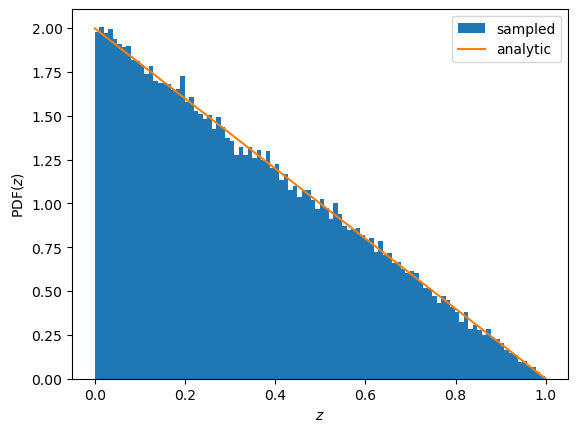

In [18]:
# Create an LFF sampler.
kinematic_sampler = StringZ(rng)

# Sample the distribution.
rzs = [kinematic_sampler.g_rand() for i in range(0, 100000)]

# Analytic z values.
azs = np.linspace(0, 1, 1000)

# Calculate the analytic g(z) values.
ags = [kinematic_sampler.g(z) for z in azs]

# Calculate normalization factor by the mid-point rule.
dz = azs[1] - azs[0]
ng = sum(ags) * dz

# Normalize the `ags`.
ags = [f / ng for f in ags]

# Create the plot.
fig, ax = plt.subplots()

# Plot a normalize histogram of the sampled values.
ax.hist(rzs, bins=100, density=True, label="sampled")
ax.set_xlabel(r"$z$")
ax.set_ylabel("PDF($z$)")

# Plot the normalized analytic LFF.
ax.plot(azs, ags, label="analytic")
ax.legend()

What is the efficiency for this sampler?

In [19]:
# Create an LFF sampler.
kinematic_sampler = StringZ(rng)

# Set the mass to sample, use the pi+.
m = pdb["pi+"].mass

# Generate 10000 random z values.
rzs = [kinematic_sampler(m) for i in range(0, 10000)]
print(f"sampling efficieny = {kinematic_sampler.e()}")

sampling efficieny = 0.21574973031283712


The efficiency of this sampler is perhaps not as good as we might like. However, the really important feature is that we do not have to specify an `fmax` for a function, rather this is determined automatically. This is particularly important if we working with a wide range of hadron masses. This becomes even more import when we also include more dimensions in the string model. In any case, we should still check that our generated distribution matches our target analytic distribution.

In [20]:
# Set up vector of z values to calculate the LFF.
azs = np.linspace(0, 1, 1000)

# Calculate the analytic LFF values.
afs = [kinematic_sampler.f(z, m) for z in azs]

# Calculate normalization factor by the mid-point rule.
dz = azs[1] - azs[0]
nf = sum(afs) * dz

# Normalize the `afs`.
afs = [f / nf for f in afs]

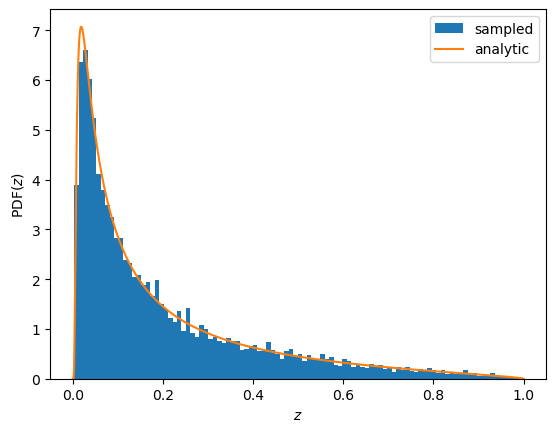

In [21]:
# Create the plot.
fig, ax = plt.subplots()

# Plot a normalize histogram of the sampled values.
ax.hist(rzs, bins=100, density=True, label="sampled")
ax.set_xlabel(r"$z$")
ax.set_ylabel("PDF($z$)")

# Plot the normalized analytic LFF.
ax.plot(azs, afs, label="analytic")
ax.legend()

## Algorithmic overview

To start, let's consider the fragmentation of the $q\bar{q}$ system in 1 + 1 dimensions $(E, p_z)$ or $(t, z)$. Later we'll see how transverse momentum is included via string breaking. In terms of the iterative program for the left-right symmetric Lund model it can be summarized as follows:

1. Randomly select from which string end the fragmentation will take place.
2. Select a new $q'\bar{q}'$ and hadron to be produced using `StringFlav`.
3. Sample $z$ according to the Lund fragmentation function using `StringZ`.
4. Compute production vertices.
5. Update all momenta.
6. Proceed through steps (1) - (5) until the center of mass energy of the new string system falls below a given cut off threshold $M^2_{\text{min}}$.

It's instructive to iterate through the algorithm a few time to get a feel for how it works. Let's assume, for simplicity, that we will only fragment from the $q$ side of the string (denoted as `fromPos` in the code). This is not how it's done in practice (equal probability between the $q$ or $\bar{q}$ end) but the simplification reduces the algorithmic complexity and readability. At the end of the day, allowing for the string to randomly fragment from either side only requires extra bookkeeping.

To start, we need to set up our $q\bar{q}$ system:

In [22]:
# Create a system of u/ubar, where each quark has an energy of 0.5 GeV.
qqbar = QQBarString(0.5, pdb["u"])

Next we need a new hadron and string end, so we use `StringFlav`. Then, we need a new $z$ for the hadron and so we use our `StringZ`. Since we are going to do this multiple times, we should probably define a function.

In [23]:
def string_next(flav, kin, end_pd, step=None):
    """
    Generate the next string end, hadron, and hadron `z`.

    flav:   flavor selector of type `StringFlav`.
    kin:    kinematic selector of type `StringZ`.
    end_pd: particle data for the string end of type `ParticleData`.
    step:   if an integer, print the step out.
    """
    # First, get the new string end and hadron.
    new_pd, had_pd = flav(end_pd)
    # Next, sample the hadron `z`.
    had_z = kin(had_pd.mass)
    # Print if requested.
    if type(step) == int:
        print(f"({step}) {end_pd.name} -> {new_pd.name}, {had_pd.name}")
        print(f"    {had_pd.name} z: {had_z:.2e}")
    return (new_pd, had_pd, had_z)

Let us generate our first new string end and hadron.

In [24]:
# Initialize the flavor selector.
flav = StringFlav(rng, pdb)

# Create a StringZ instance.
kin = StringZ(rng)

# Get the end `ParticleData` of the string (from the q end).
end0_pd = qqbar.q.data

# Generate the new string end, hadron, and hadron `z` for step 1.
end1_pd, had1_pd, had1_z = string_next(flav, kin, end0_pd, 1)

(1) u -> d, pi-
    pi- z: 4.57e-01


Now we can compute the string break vertices. From the [String Coordinates](#scrollTo=String_Coordinates) we have the following.

$$
x^+_i = z_i \prod_{j = 0}^{i-1}(1 - z_j)
$$

$$
x^-_i = \frac{m_i^2}{x^+_i M^2}
$$

$$
\hat{x}^+_i = \hat{x}^+_{i-1} - x^+_i
$$

$$
\hat{x}^-_i = \hat{x}^-_{i-1} + x^-_i
$$

For the initial step, before any hadrons have been produced, we have $z_0 = 0$, $\hat{x}^+_0 = 1$, and $\hat{x}^-_0 = 0$. This then gives us the following for the first step.

$$
x^+_1 = z_1
$$

$$
x^-_1 = \frac{m_1^2}{x^+_1 M^2}
$$

$$
\hat{x}^+_1 = 1 - z_1
$$

$$
\hat{x}^-_1 = \frac{m_1^2}{x^+_1 M^2}
$$

Again, since we are going to be doing this a few times, it's useful to define a function that does this for us.

In [25]:
def string_vertex(string, xhp0, xhm0, prod_z, had_z, had_pd, step=None):
    """
    Calculate the string vertex. Returns (x^+, x^-, xhat^+, xhat^-) of the
    current step.

    xhp0:   xhat^+ of the previous step.
    xhm0:   xhat^- of the previous step.
    prod_z: product of (1 - z) up to this step.
    had_z:  hadron z of this step.
    had_pd: hadron `ParticleData` of the current step.
    """
    xp = had_z * prod_z
    xm = had_pd.mass**2 / (xp * string.m2)
    xhp = xhp0 - xp
    xhm = xhm0 + xm
    if type(step) == int:
        print(f"({step}) x^+   : {xp:8.2e}, x^-   : {xm:8.2e}")
        print(f"    xhat^+: {xhp:8.2e}, xhat^-: {xhm:8.2e}")
    return (xp, xm, xhp, xhm)

In [26]:
# Set our initial values.
prod_z = 1
xhp0 = 1
xhm0 = 0

# Calculate the string vertex.
xp1, xm1, xhp1, xhm1 = string_vertex(qqbar, xhp0, xhm0, prod_z, had1_z, had1_pd, 1);

(1) x^+   : 4.57e-01, x^-   : 4.26e-02
    xhat^+: 5.43e-01, xhat^-: 4.26e-02


It will be useful to visualize each break on the light-cone "unit square". We building an actual version of the figure from the [String Coordinates](scrollTo=String_Coordinates) section. Again, since we will be doing this multiple times, it is useful to define a function which make this plot.

In [27]:
def string_plot(xhps, xhms, nmax=None):
    """
    Plot the breaks of a string.

    xhps: xhat^+ coordinates for the vertices.
    xhms: xhat^- coordinates for the vertices.
    nmax: maximum number of breaks to plot. If `None`, then determine from
          the passed list of coordinates.
    """
    # Create the plot.
    fig = plt.figure()

    # We typically look at this type of plotted rotated by 45 degrees,
    # so we define a transformation here.
    transform = Affine2D().rotate_deg(45)
    helper = GridHelperCurveLinear(transform, extremes=(0, 1, 0, 1))
    ax = FloatingSubplot(fig, 111, grid_helper=helper)
    fig.add_subplot(ax)

    # Create auxiliary axis to plot in original coordinates.
    aux_ax = ax.get_aux_axes(transform)

    # Axis labels.
    ax.axis["left"].label.set_text(r"$\hat{x}^-$")
    ax.axis["left"].label.set_pad(25)
    ax.axis["left"].label.set_rotation(0)
    ax.axis["bottom"].label.set_text(r"$\hat{x}^+$")
    ax.axis["bottom"].label.set_pad(15)
    ax.axis["bottom"].major_ticklabels.set_rotation(270)

    # Create a color map with distinct colors based on the number of vertices.
    if nmax == None:
        nmax = len(xhps)
    colors = plt.cm.rainbow(np.linspace(0, 1, nmax))

    # Loop over the coordinates and draw lines for each vertex.
    for i, (xhp, xhm) in enumerate(zip(xhps, xhms)):
        # Draw a dotted line at xhat^+.
        aux_ax.plot([xhp, xhp], [0, 1], linestyle="--", color=colors[i], linewidth=0.5)
        # Draw a dotted line at xhat^+.
        aux_ax.plot([0, 1], [xhm, xhm], linestyle="--", color=colors[i], linewidth=0.5)
        # Plot a point at the intersection.
        aux_ax.plot(xhp, xhm, "o", markersize=5, color=colors[i])

    # Add a grid.
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.set_aspect("equal")
    return fig, ax

We now use this function to plot the breaks.

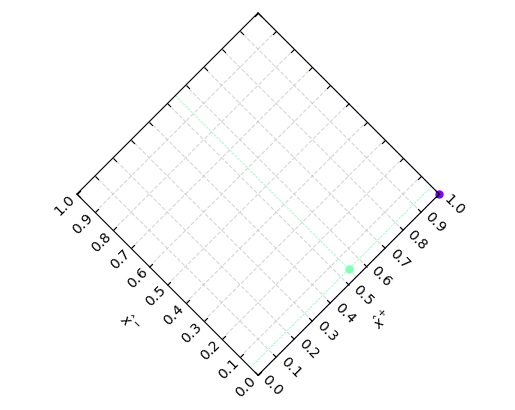

In [28]:
# Plot the vertices up to this point. We are going to look at 3 vertices, so
# we set `nmax` to 3.
string_plot([xhp0, xhp1], [xhm0, xhm1], 3);

Let's do the second iteration, which is a little more interesting

In [29]:
# Generate the new string end, hadron, and hadron `z` for step 2.
end2_pd, had2_pd, had2_z = string_next(flav, kin, end0_pd, 2)

(2) u -> d, pi-
    pi- z: 1.76e-01


For the second vertex, we can again work out what our vertex coordinates are.

$$
x^+_2 = z_2 (1 - z_1)
$$

$$
x^-_2 = \frac{m_2^2}{x^+_2 M^2}
$$

$$
\hat{x}^+_2 = \hat{x}^+_1 - x^+_2
$$

$$
\hat{x}^-_2 = \hat{x}^-_1 + x^-_2
$$

Since we already defined a function that does this calculation, we can just use that.

In [30]:
# Update the product of (1 - z).
prod_z *= 1 - had1_z

# Calcuate the next string vertex.
xp2, xm2, xhp2, xhm2 = string_vertex(qqbar, xhp1, xhm1, prod_z, had2_z, had2_pd, 2);

(2) x^+   : 9.56e-02, x^-   : 2.04e-01
    xhat^+: 4.48e-01, xhat^-: 2.46e-01


And we can plot the vertices again.

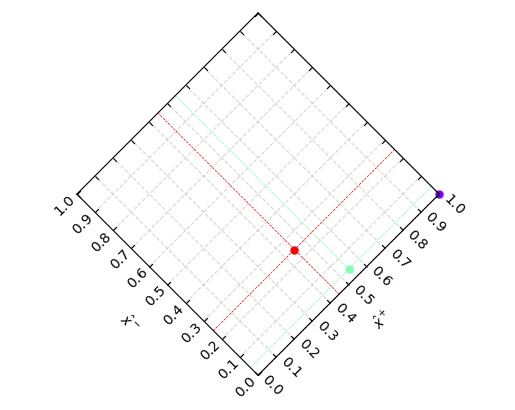

In [31]:
# Plot the vertices up to this point.
string_plot([xhp0, xhp1, xhp2], [xhm0, xhm1, xhm2], 3);

Rinse and repeat. Eventually we will get to a point where energy and momentum conservation of the outgoing hadrons should creep up on us. For example, we will eventually reach a point where the remaining string mass is too small to produce any hadrons that we have access to - we should stop the fragmentation chain before we get here so we can maybe do something a little smarter. A possibly good condition would be to stop right around when the remaining area is roughly the size of two of the largest hadron masses that we can produce (remember, the last vertex that we select is actually producing the final two hadrons), which in our case, is just two pions

$$
\hat{x}^+_n(1 - \hat{x}^-_n)M^2 \approx (2m_\pi)^2
$$

## Iterative fragmentation

Before we implement the full algorithm, we need to be able to convert from the momentum fractions to (in principle observable) hadron four-momenta. Consider the four-vectors
$$
P_{q/\bar{q}}^{\mu} \equiv E(1, 0, 0, \pm 1)
$$
(in our language these are just four-momenta of the $q\bar{q}$ system that we initialize in `QQBarString` as `self.q_p`. `self.qbar_p`), and remember that the $i$-th ($i \in 1, ..., N_h$) hadron coordinate can be described generically by
$$
x_{i}^+ = \hat{x}_{i-1}^+ - \hat{x}_i^+,
$$
$$
x_{i}^- = \hat{x}_i^- - \hat{x}_{i-1}^-
$$
with $\hat{x}^+_0 = 1, \hat{x}^-_0 = 0$. The hadron momentum is then fully described by the system of equations
$$
  	p^\mu_{i} = x_{i}^+ P^\mu_q + x_{i}^- P^\mu_{\bar{q}}
$$
or simply
$$
    E_{i} = E(x^+_{i} + x^-_{i}), \hspace{0.3in} p_{z, i} =  E(x^+_{i} - x^-_{i})
$$
constrained by the condition
$$
    m_{i}^2 = p_{i}^2 = x^+_{i}x^-_{i} M^2.
$$
In practice, given the mass of the new hadron $m_{i}$ and longitudinal momentum fraction $z_i$, we'll compute the new vertex $i$ via
$$
    x^{+}_{i} = z^{+}_{i}\prod_{j=1}^{i-1}(1-z^{+}_j) \quad \text{for } \,\, i > 1
$$
$$
    x^{-}_{i} = \frac{m^2_{i}}{x^{+}_{i}M^2}
$$
where $z^{+}_0 = 0$. Finally, the position ($\hat{x}^+_i, \hat{x}^-_i$) of the $i$-th vertex can also be found recursively using the expressions above
$$
\hat{x}^+_i = \hat{x}^+_{i-1} - x_i^+ = (1 - z_i) \hat{x}^+_{i-1}
$$
$$
\hat{x}^-_i = \hat{x}^-_{i-1} + x_i^-.
$$

Let's build out a `StringFragmentation` class below that will take as input `QQBarString`, `StringFlav`, and `StringZ` instances and recursively fragment the string system resulting in an event record consisting of hadron four-momenta.

In [32]:
class StringFragmentation:
    """
    Hadronization class using the Lund string model.
    """

    def __init__(self, flav, kin):
        """
        Initialize the hadronization class.

        flav:   flavor selector of type `StringFlav`.
        kin:    kinematic sampler of type `StringZ`.
        """
        # Store the samplers.
        self.flav = flav
        self.kin = kin

    def __call__(self, system, steps=None, nmax=1000):
        """
        Hadronize the string passed by `system`.

        system: the string system of type `QQbarString` to hadronize.
        steps:  if `True`, print the hadronization steps.
        nmax:   the number of hadronization steps allowed.
        """
        # Keep a record of the event, starting with the initial string.
        self.event = [system.q, system.qbar]

        # Initialize arrays for the light-cone coordinates, z, and string end.
        self.xhps = [1]
        self.xhms = [0]
        self.xps = [0]
        self.xms = [0]
        self.had_zs = [0]
        self.end_pds = [system.q.data]
        self.prod_z = 1

        # Enter the hadronization loop.
        for i in range(0, nmax):
            # Flag to print the hadronization steps.
            step = i + 1 if steps else None

            # Determine the flavor and kinematics. We already wrote this!
            end_pd, had_pd, had_z = string_next(
                self.flav, self.kin, self.end_pds[-1], step
            )

            # Calculate the vertex the coordinates. We already wrote this!
            xp, xm, xhp, xhm = string_vertex(
                system, self.xhps[-1], self.xhms[-1], self.prod_z, had_z, had_pd, step
            )

            # Return if this vertex is unphysical or the stopping condition
            # is met.
            if (
                xhm > 1.0
                or xhp < 0.0
                or xhp * (1 - xhm) * system.m2 < (2 * self.flav.pdb["pi+"].mass) ** 2
            ):
                return

            # Determine the hadron momentum.
            e = system.e * (xp + xm)
            pz = system.e * (xp - xm)

            # Append the hadron to the event record.
            self.event += [Particle(had_pd, FourVector(e, 0, 0, pz), 0)]

            # Update the fragmentation state.
            self.xps += [xp]
            self.xms += [xm]
            self.xhps += [xhp]
            self.xhms += [xhm]
            self.had_zs += [had_z]
            self.end_pds += [end_pd]
            self.prod_z *= 1 - had_z

In [33]:
# Initialize the fragmentation class.
flavor_selector = StringFlav(rng, pdb)
kinematic_sampler = StringZ(rng)
hadronizer = StringFragmentation(flavor_selector, kinematic_sampler)

# Create the system, u/ubar at 3 GeV.
qqbar = QQBarString(3.0, pdb["u"])

# Hadronize, and print the steps.
hadronizer(qqbar, True)

(1) u -> d, pi-
    pi- z: 4.02e-01
(1) x^+   : 4.02e-01, x^-   : 1.35e-03
    xhat^+: 5.98e-01, xhat^-: 1.35e-03
(2) d -> d, pi0
    pi0 z: 5.25e-02
(2) x^+   : 3.14e-02, x^-   : 1.61e-02
    xhat^+: 5.66e-01, xhat^-: 1.75e-02
(3) d -> d, pi0
    pi0 z: 5.22e-01
(3) x^+   : 2.96e-01, x^-   : 1.71e-03
    xhat^+: 2.70e-01, xhat^-: 1.92e-02
(4) d -> u, pi+
    pi+ z: 4.75e-02
(4) x^+   : 1.29e-02, x^-   : 4.21e-02
    xhat^+: 2.58e-01, xhat^-: 6.13e-02
(5) u -> u, pi0
    pi0 z: 2.83e-02
(5) x^+   : 7.30e-03, x^-   : 6.93e-02
    xhat^+: 2.50e-01, xhat^-: 1.31e-01
(6) u -> d, pi-
    pi- z: 8.33e-02
(6) x^+   : 2.08e-02, x^-   : 2.60e-02
    xhat^+: 2.29e-01, xhat^-: 1.57e-01
(7) d -> u, pi+
    pi+ z: 2.89e-02
(7) x^+   : 6.63e-03, x^-   : 8.16e-02
    xhat^+: 2.23e-01, xhat^-: 2.38e-01
(8) u -> d, pi-
    pi- z: 3.74e-01
(8) x^+   : 8.33e-02, x^-   : 6.50e-03
    xhat^+: 1.40e-01, xhat^-: 2.45e-01
(9) d -> d, pi0
    pi0 z: 5.93e-01
(9) x^+   : 8.28e-02, x^-   : 6.11e-03
    xhat^+: 5

In [34]:
# Print the event record.
for prt in hadronizer.event:
    print(
        f"{prt.data.name:6s}:"
        f" {prt.p[0]:9.2e} {prt.p[1]:9.2e} {prt.p[2]:9.2e} {prt.p[3]:9.2e}"
    )

u     :  3.00e+00  0.00e+00  0.00e+00  3.00e+00
ubar  :  3.00e+00  0.00e+00  0.00e+00 -3.00e+00
pi-   :  1.21e+00  0.00e+00  0.00e+00  1.20e+00
pi0   :  1.43e-01  0.00e+00  0.00e+00  4.58e-02
pi0   :  8.93e-01  0.00e+00  0.00e+00  8.83e-01
pi+   :  1.65e-01  0.00e+00  0.00e+00 -8.78e-02
pi0   :  2.30e-01  0.00e+00  0.00e+00 -1.86e-01
pi-   :  1.40e-01  0.00e+00  0.00e+00 -1.53e-02
pi+   :  2.65e-01  0.00e+00  0.00e+00 -2.25e-01
pi-   :  2.69e-01  0.00e+00  0.00e+00  2.30e-01
pi0   :  2.67e-01  0.00e+00  0.00e+00  2.30e-01
pi+   :  1.44e-01  0.00e+00  0.00e+00 -3.47e-02


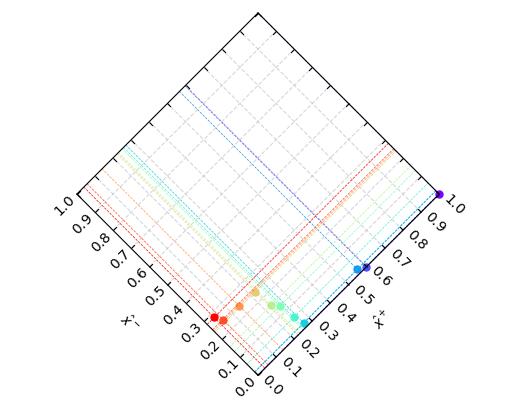

In [35]:
# Plot the vertices.
string_plot(hadronizer.xhps, hadronizer.xhms);

What happens if we make a 2D histogram of $\hat{x}^+_i$ and $\hat{x}^-_i$ for a number of events, rather than a scatter plot for just one event?

In [36]:
# Vectors to store xhat^+ and xhat^-.
xhps = []
xhms = []

# Loop over the events.
for i in range(0, 10000):
    # Hadronize the system.
    hadronizer(qqbar)

    # Append the values (but not the first).
    xhps += hadronizer.xhps[1:]
    xhms += hadronizer.xhms[1:]

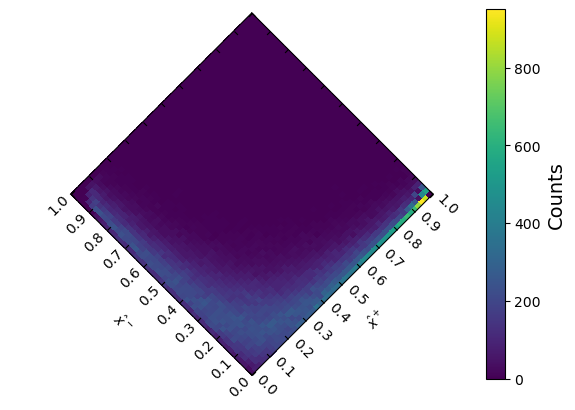

In [37]:
# Create the plot.
fig = plt.figure()

# Rotate the plot by 45 degrees as usual.
transform = Affine2D().rotate_deg(45)
helper = GridHelperCurveLinear(transform, extremes=(0, 1, 0, 1))
ax = FloatingSubplot(fig, 111, grid_helper=helper)
fig.add_subplot(ax)

# Create auxiliary axis to plot in original coordinates.
aux_ax = ax.get_aux_axes(transform)

# Axis labels.
ax.axis["left"].label.set_text(r"$\hat{x}^-$")
ax.axis["left"].label.set_rotation(0)
ax.axis["left"].label.set_pad(25)
ax.axis["bottom"].label.set_text(r"$\hat{x}^+$")
ax.axis["bottom"].label.set_pad(15)
ax.axis["bottom"].major_ticklabels.set_rotation(270)

# Create the histogram.
_, _, _, hist_xhat_pm = aux_ax.hist2d(
    xhps, xhms, bins=50, range=[[0, 1], [0, 1]], cmap="viridis"
)

# Add a colorbar
cbar = fig.colorbar(hist_xhat_pm, ax=ax, orientation="vertical", fraction=0.04, pad=0.1)
cbar.set_label("Counts", size=14)

You'll see above that the vertices seem to follow some sort of hyperbolic distribution - this can be traced back to some interesting physics! Generically, the unnormalized probability for a string break to fragment into an $n$-particle final state is given by

$$
dP_n = \prod_{j = 1}^n N_j dp_j \delta(p_j^2 - m_j^2) \delta\left( \sum_{j=1}^n p^\mu_j - P^\mu_{\text{string}} \right) \exp(-b \mathcal{A}),
$$

where $\mathcal{A}$ represents the area spanned by the string before the breakup. The probability roughly factorizes into the product of $n$-body phase-space with an exponential area suppression.

This competition leads to an interesting compromise. On one hand, phase space wants to pack in as many hadrons as possible, which tends to push fragmentation vertices closer together in time. On the other hand, the exponential suppression penalizes any configuration that sweeps out too much area, i.e., configurations where hadrons are produced too far apart in time or space.

The balance point turns out to be when each breakup contributes roughly the same invariant area. That is, the most probable configurations are those where the fragmentation vertices lie along curves of constant invariant time:

$$
\tau^2 = t^2 - z^2 = \text{const}.
$$

These hyperbolae strike a balance between maximizing multiplicity and minimizing total area. Physically, this means that the string fragments in a boost-invariant fashion.

This structure has important observable consequences, for example the coordinate-space rapidity of a vertex is defined as

$$
\eta = \frac{1}{2} \ln\left(\frac{t + z}{t - z}\right),
$$

and since the vertices lie along a fixed $\tau$, their density in $\eta$ is approximately uniform.

This geometric picture is also encoded in our Lund plane that we constructed above. To see this we introduce the the the squared invariant time (from the origin of the initial $q\bar{q}$ pair) to a string break vertex

$$
\Gamma = (\kappa \tau)^2 = \kappa^2 (t^2 - x^2 - y^2 - z^2).
$$

In the energy-momentum picture, this is simply given by

$$
\Gamma_i = (\hat{x}^+_i P^+ + \hat{x}^-_i P^-)^2 = \hat{x}_i^+ \hat{x}_i^- M^2,
$$

which corresponds geometrically to the string area in the backwards light cone of the vertex. The area suppression factor from above then becomes

$$
\exp(-b \mathcal{A}) = \exp\left(-b \sum_i \Gamma_i \right).
$$

To avoid exponential suppression, the hadronization configurations will prefer for each $\Gamma_i$ to be small but roughly equal, i.e., each hadron is produced along a contour of constant $\hat{x}^+ \hat{x}^-$, which traces out a hyperbola on the unit square (as we see above!). This is a direct imprint of the same physical principle above: balancing the statistical pressure to produce many hadrons with the geometric penalty for large invariant area.

Similar to the coordinate space rapidity, $\eta$, we can clearly see that the momentum-space rapidity

$$
y = \frac{1}{2} \ln\left(\frac{E + p_z}{E - p_z}\right) = \frac{1}{2} \ln\left(\frac{p^+}{p^-}\right) = \frac{1}{2} \ln\left(\frac{x^+}{x^-}\right)
$$

will also remain roughly constant i.e. the number of particles produced, $N$, per unit rapidity

$$
\frac{dN}{dy} \approx \text{const}.
$$

To summarize, the area suppression sculpts the entire fragmentation pattern into hyperbolic structure that ensures boost invariance and a flat rapidity distribution. The latter was an experimental motivation for the Lund string model.

## Observables

Before we continue on to incorporating tranverse momentum, let's look at some observables.

### Exercise: multiplicity

Because hadronization is non-perturbative, quite a bit of work in high energy particle physics has gone into creating observables that do not depend strongly on hadronization, e.g., inclusive cross-sections, jet physics, etc. However, there are number of variables are very sensitive to hadronization, one of them being the final state multiplicity. Run the hadronization for $10000$ events and make a histogram of the event multiplicity.

In [38]:
# Initialize the fragmentation class.
flavor_selector = StringFlav(rng, pdb)
kinematic_sampler = StringZ(rng)
hadronizer = StringFragmentation(flavor_selector, kinematic_sampler)

# Create the system, u/ubar at 3 GeV.
qqbar = QQBarString(3.0, pdb["u"])

# Create a list of mutiplicity.
ns = []

# Generate 10000 events.
for i in range(10000):
    hadronizer(qqbar)
    # Append the number of hadrons. Account for the initial quarks.
    ns += [len(hadronizer.event) - 2]
####STOP_SOLUTION

We can plot the multiplicity distribution now.

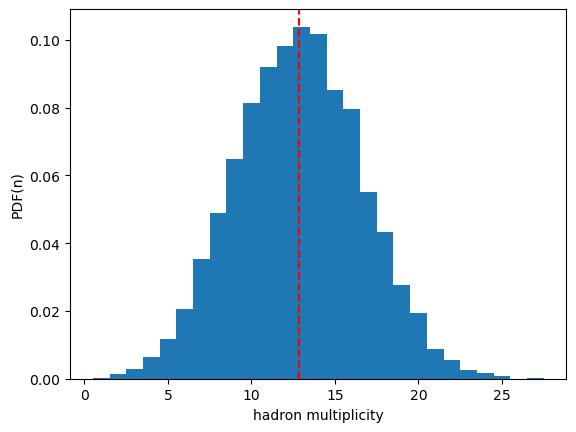

In [39]:
# Plot the distribution.
fig, ax = plt.subplots()

# Construct a binning. We have to be a little careful of binning effects
# to make sure each bin covers a single multiplicity.
bins = [n - 0.5 for n in range(min(ns), max(ns) + 2)]

# Plot the histogram of multiplicity.
ax.hist(ns, bins=bins, density=True)

# Plot the average multiplicity as a vertical line.
ax.axvline(
    sum(ns) / len(ns),
    color="red",
    linestyle="--",
)

# Set the labels.
ax.set_xlabel("hadron multiplicity")
ax.set_ylabel("PDF(n)");

### Exercise: rapidity

The multiplicity distribution, differential in hadron rapidity $y$, is also an important observable when considering hadronization. Use the definition for rapidity above and plot this distribution. Again, generate $10000$ events.

In [40]:
def rapidity(p):
    """
    Return the rapidity for a four vector.
    y = 1/2 ln((E + p_z)/(E - p_z))

    p: four vector of type `FourVector`.
    """
    return math.log((p[0] + p[3]) / (p[0] - p[3])) / 2

In [41]:
# Initialize the fragmentation class.
flavor_selector = StringFlav(rng, pdb)
kinematic_sampler = StringZ(rng)
hadronizer = StringFragmentation(flavor_selector, kinematic_sampler)

# Create the system, u/ubar at 3 GeV.
qqbar = QQBarString(3.0, pdb["u"])

# Create a list of rapidities.
ys = []

# Generate 10000 events.
for i in range(10000):
    hadronizer(qqbar)
    # Loop over the particles, skip the initial quarks.
    for prt in hadronizer.event[2:]:
        # Calculate and append the rapidity.
        ys += [rapidity(prt.p)]
####STOP_SOLUTION

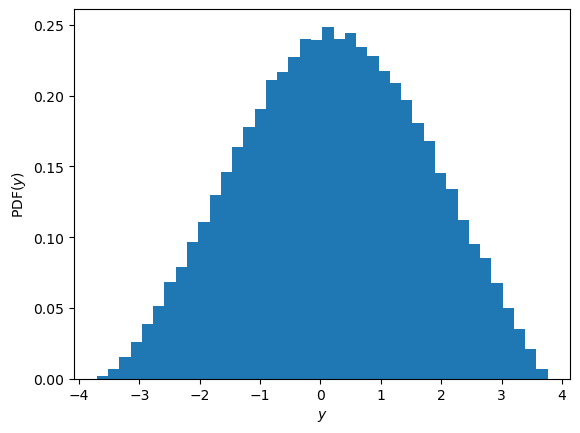

In [42]:
# Create the plot.
fig, ax = plt.subplots()

# Plot the histogram of rapidity. Use 40 bins.
ax.hist(ys, bins=40, density=True)

# Set the labels.
ax.set_xlabel(r"$y$")
ax.set_ylabel("PDF($y$)");

We mentioned above that the rapidity distribution should be flat? What is going on? The caveat to the statements above is that they hold primarily in the limit of "infinitely long" or very massive strings. The reason for this is because the relation doesn't hold near the end of the string.

### Exercise: rapidity energy dependence

 Let's take a look at the scaling of the rapidity distribution as a function of the string mass. Plot the rapidity distribution for initial quark energies of $5$, $10$, $25$, and $50$ GeV. Generate only $1000$ events per energy to speed things up a bit.

In [43]:
# Initialize the fragmentation class.
flavor_selector = StringFlav(rng, pdb)
kinematic_sampler = StringZ(rng)
hadronizer = StringFragmentation(flavor_selector, kinematic_sampler)

# Create a dictionary rapidities with energy keys.
es = {e: [] for e in (5, 10, 25, 50)}

# Loop over the energies.
for e, ys in es.items():
    # Create the system, u/ubar at the given energy.
    qqbar = QQBarString(e, pdb["u"])

    # Generate 5000 events.
    for i in range(1000):
        hadronizer(qqbar)
        # Loop over the particles, skip the initial quarks.
        for prt in hadronizer.event[2:]:
            # Calculate and append the rapidity.
            ys += [rapidity(prt.p)]

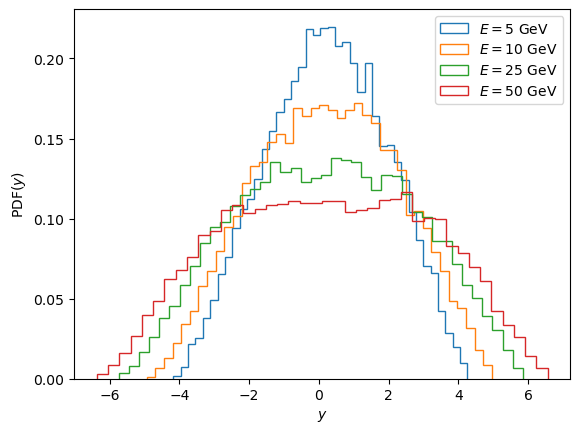

In [44]:
# Create the plot.
fig, ax = plt.subplots()

# Loop over the energies.
# Plot the histogram of rapidity. Use 40 bins.
# The `histtype` argument plots just a line.
# Label the histogram.
for e, ys in es.items():
    ax.hist(ys, bins=40, density=True, histtype="step", label=f"$E = {e}$ GeV")

# Set the labels and create a legend.
ax.set_xlabel(r"$y$")
ax.set_ylabel("PDF($y$)")
ax.legend();

## Including $p_T$

Up until now we have worked exclusively in 1+1 dimensions with each string break (and therefore each hadron) having no transverse momenta. For a realistic hadronization simulation $p_T$ generation must be incorporated!

In the Lund string model, each string break corresponds to the nonperturbative creation of a $q'\bar{q}'$ pair from the vacuum. This is modeled as a quantum tunneling process through the linear confining potential of the string. According to the uncertainty principle, this pair can have non-zero momentum transverse to the string axis. Since they are produced locally, momentum conservation requires that the transverse momenta of the quark and antiquark be equal and opposite i.e., each string break introduces a local transverse momentum kick, with

$$
\vec{k}_\perp^{(q')} = -\vec{k}_\perp^{(\bar{q}')}.
$$

The resulting hadron inherits this transverse momentum when a quark from one break and an antiquark from the next recombine.

The tunneling probability for producing a quark of mass $m_q$ and transverse momentum $p_\perp$ is given by the Schwinger-like exponential suppression:

$$
\mathcal{P}(m_q, p_\perp) \propto \exp\left( -\frac{\pi (m_q^2 + p_\perp^2)}{\kappa} \right)
$$

where $\kappa \sim 1\,\mathrm{GeV}/\mathrm{fm} \simeq 0.2\,\mathrm{GeV}^2$ is the string tension. Note that heavier quarks and large transverse momenta are exponentially suppressed. Thus, strange quark production is rarer than up/down, and charm production is highly suppressed.

### Algorithmic overview

Fortunately, the iterative algorithm only requires minimal changes and can be largely summarized with the transformation: $m^2 \to m^2_\perp \equiv m^2 + p_T^2$ where $m_\perp$ is the transverse mass.

In light-cone coordinates, transverse momentum components completely factorize from the longitudinal components (they are orthogonal). All light-cone variable definition remain the same as defined previously with the key change coming from the on-shell condition:

$$
p^+ p^- = m^2 + p_T^2 \equiv m_\perp^2.
$$

Likewise, the momentum fractions become

$$
x^+ x^- = \frac{m_\perp^2}{M^2}.
$$

Because $p_T$ completely factorizes (in terms of it's generation) the $p_T$ of the $i$-th hadron can be computed recursively via the string end transverse momentum $\vec{k}_T$

$$
\vec{p}_{T,i} = \vec{k}_{T,i} - \vec{k}_{T, i-1}, \quad \text{with} \quad \vec{k}_{T,0} = 0.
$$

Clearly the first hadron will have the same $p_T$ as the first string break $\vec{k}_{T,1}$, while the second hadron will inherit $p_T$ that is the vector sum of the first string break (whose conjugate end imparted some equal and opposite $\vec{k}_T$ on the leftover string system) and the $\vec{k}'_T$ of the new string break.

### Sampling $z$

Even though the fragmentation happens longitudinally, the string area law (which governs hadron production probability) becomes sensitive to the full mass of the hadron, including transverse motion. So transverse momentum acts like an effective mass penalty - heavier hadrons or those with larger $p_T$ are suppressed. As you may have guessed, the fragmentation function becomes:

$$
f(z, p_\perp^2) \propto \frac{1}{z}(1 - z)^a \exp\left( -b\frac{m^2_\perp}{z} \right).
$$

Note that this implies that when determining kinematics, we first need to generate the string-end transverse momentum components before determining the longitudinal component.

### Sampling $p_T$

In practice, the transverse momentum of the produced hadron is sampled at each string break, assuming that the distribution is azimuthally symmetric.

The transverse momentum is sampled from a 2D Gaussian:

$$
f(\vec{p}_\perp = p_x,p_y) = \mathcal{N}(p_x,0,\sigma)\mathcal{N}(p_y,0,\sigma)
\quad \text{with} \quad \sigma^2 \approx \frac{\kappa}{\pi}
$$

where $\sigma$ is a tuneable parameter fit from experimental data. In Pythia, the default value is typically $\sigma \sim 0.3$ GeV.

### Exercise: tuning

Throughout this tutorial we have chosen the Lund model parameters based off of the current Pythia defaults: `a = 0.68, b = 0.98, sigma = 0.335`. Change these parameters and investigate how this changes the observables of interest. Think about how you could set up an iterative tuning of these parameters if given experimental data.

As a challenge, set up a mock tuning exercise using two simulated samples (of observables) at different parameterizations. Set one as the "experimental" dataset and the other as output from the simulation. See also the `tuning.ipynb` tutorial. We do not provide a solution for this exercise as it is more open-ended exploration.